In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


snippet for duration reporting

In [ ]:
timestamp_start = datetime.datetime.now()

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))

# [ IMPORTS ]

In [1]:
import datetime
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import statistics as stats
import scipy.signal as scsig

import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Input, LSTM, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Using TensorFlow backend.


# [ GLOBAL ]

In [2]:
# Resample every signal to this rate for consistency
BASIC_SRATE = 128 #Hz
print('Basic sampling rate(Hz): '+str(BASIC_SRATE))


#=================================================
# working directories
#=================================================

# > _ base working directory
global_dir = '/content/drive/My Drive/Masters/workdir/ecg_data'
print('GLOBAL DIR :: '+global_dir)

# >> global MAT directory, contains signal data in matlab (.mat) format
global_matdir = os.path.join(global_dir, 'db_mat') 
print('GLOBAL MAT DIR :: '+global_matdir)

# >> global NPY directory, contains signal and meta data in numpy (.npy) format
global_npydir = os.path.join(global_dir, 'db_npy') 
print('GLOBAL NPY DIR :: '+global_npydir)

# >> global datasets directory, contains manually generated datasets
global_dsdir = os.path.join(global_dir, 'db_dataset') 
print('GLOBAL DATSET DIR :: '+global_dsdir)

# >> model directory, contains model weights and test results use load_weights(), save_weights() 
global_modeldir = os.path.join(global_dir, 'db_model')
print('GLOBAL MODEL DIR :: ' + global_modeldir)

#>>----------------------------------------------- 


#=================================================
# Annotations
#=================================================
# >> annotation directory, contains annotation mapping files to be used for experiments
global_antdir = os.path.join(global_dir, 'db_ant') 
print('GLOBAL ANNOTATION DIR :: ' + global_antdir)
#>>----------------------------------------------- 


#=================================================
# File Identifiers
#=================================================
# beat and non-beat annotations, signal data types to be used to save data in npy format
g_BA = 'BA'                     #<<--- beat annotations (@orignal Sampling rate)
g_NBA = 'NBA'                   #<<--- non-beat annotations (@orignal Sampling rate)
g_RAW2 = 'RAW2'                 #<<--- Raw lead2 signal from mat file
g_BLF2 = 'BLF2'                 #<<--- Baseline fitted signal
g_RES2 = 'RES2'                 #<<--- Resampled to BASIC_SRATE

g_SIG2 = 'SIG2'     #<<--- Removed manual gain
g_RPEAK = 'RRP'     #<<--- Resampled R-peaks
#>>----------------------------------------------- 

Basic sampling rate(Hz): 128
GLOBAL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data
GLOBAL MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat
GLOBAL NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy
GLOBAL DATSET DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset
GLOBAL MODEL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_model
GLOBAL ANNOTATION DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_ant


# [ CLASS DEFINITIONS ]

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_db : represents one ECG database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_db:
    def __init__(self, dbname,  tag_recs):
        print('\nInitailze new ecg database ... ')
        self.name = dbname  #str
        self.dir_npy = os.path.join(global_npydir , dbname+'_npy') #str
        self.recs = set(np.loadtxt(os.path.join(self.dir_npy,'RECORDS'), dtype='str',delimiter="\n")) #set
        self.recs_tag = set(tag_recs)
        self.recs_dict = {} # initially empty, will be loaded on demand using function 'get_record'
        self.info()

    def info(self):
        print( 'DB NAME :: '+ self.name)
        print( 'DATA DIR :: ' + self.dir_npy )
        print( 'RECORDS :: [' +str(len(self.recs))+'] ' + str(self.recs) )
        print( 'TAG RECORDS :: [' +str(len(self.recs_tag))+'] ' + str(self.recs_tag))
        return 0

    def get_record(self,rec):
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]
    
    def get_random_record(self, recset):
        rec = random.choice(list(recset))
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]

#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_record : represents one ECG Record in any database
#---------------------------------------------------------------------------------------------------------------------------------------------
g_SUPRESS_DATA_WARNING=False
class ecg_record:

    def __init__(self, db, recname):
        self.db = db                                # class:{ecg_db}    object this record belongs to
        self.rec = recname                          # string            name of this record
        self.name = db.name + '_'+ recname          # string            full name including db.name
        if not recname in db.recs:
            print('WARNING:: Record "'+ recname +'" not found in database '+ db.name )
        self.data_npy = {}                          # dict dict of data file content used in self.read_data_npy('key')
        self.data_temp = {}                          # dict dict of data file content used in self.read_data_temp('key')
        self.binfo = None                           # class binfo       

##<------------------------------------------------- get instance of binfo class
    def read_binfo(self):
        if self.binfo == None:
            self.binfo = ecg_binfo(self)
        return self.binfo

    def refresh_binfo(self):
        self.binfo = ecg_binfo(self)
        return self.binfo

##<------------------------------------------------- data reading for npydir
    def load_data(self, data_type):
        ipath = os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data_npy[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
            return self.data_npy[data_type] #= np.load(self.dirs[s])
        except:
            if g_SUPRESS_DATA_WARNING == False:
                print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            return np.array([])
        
    def read_data(self, data_type):
        if data_type in self.data_npy.keys():
            return self.data_npy[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data(data_type)

##<------------------------------------------------- for tempdir
    def load_data_temp(self, data_type, dir_path):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data_temp[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
            return self.data_temp[data_type] #= np.load(self.dirs[s])
        except:
            if g_SUPRESS_DATA_WARNING == False:
                print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            return np.array([])
        
    def read_data_temp(self, data_type, dir_path):
        if data_type in self.data_temp.keys():
            return self.data_temp[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data_temp(data_type, dir_path)

    def save_data_temp(self, data_type, data_array, dir_path):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        np.save(ipath, data_array)
        return ipath

    def del_data_temp(self, data_type, dir_path, vb):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        if os.path.exists(ipath):
            if vb:
                print('Removing: '+str(ipath))
            os.remove(ipath)
            return 1
        else:
            return 0
#------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_binfo : information about beats in a record
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_binfo:
    def __init__(self, rec):
         
        # the record object
        self.rec = rec
        
        # read orignal annotations
        r_peaks_ants = rec.read_data(g_RPEAK)       # resampled ant file
        
        # calculate count of R peaks (excluding first and last)
        self.rp_count = len(r_peaks_ants) - 2
        
        # Extract Location and Labels of Peaks (exclude first and last beat)
        r_peaks_int = r_peaks_ants[:,0].astype('int')
        r_ants_str = r_peaks_ants[:,1]
        
        #self.rp_first = r_peaks_int_raw[0] # = self.rp_prev[0]
        #self.rp_last = r_peaks_int_raw[-1] # = self.rp_next[-1]
        
        # Location
        self.rp_curr = r_peaks_int[1:-1]    # current R peak
        self.rp_prev = r_peaks_int[0:-2]    # previous R peak (in samples)
        self.rp_next = r_peaks_int[2:]      # next R peak (in samples)
        
        # Label
        self.rl_curr = r_ants_str[1:-1]
        self.rl_prev = r_ants_str[0:-2]
        self.rl_next = r_ants_str[2:]

        # mapped Label
        self.rli_prev = []
        self.rli_curr = []
        self.rli_next = []

        # calculate temporal info
        self.rp_sec = self.rp_curr / BASIC_SRATE                 # peak location (in sec)
        self.rri_prev = (self.rp_curr - self.rp_prev) / BASIC_SRATE   # prev RRI (in sec) 
        self.rri_next = (self.rp_next - self.rp_curr) / BASIC_SRATE   # next RRI (in sec) 
        self.rri_delta = (self.rri_next - self.rri_prev)              # difference b/w prev and next RRI (in sec) 
        self.rri_dur = (self.rri_next + self.rri_prev)                # total duration from prev to next R-peak
        

    def get_signal_data_var(self, ith_peak): # data_type = g_SIG_II_POSTFIX
        # prev peak to next peak
        sel_sig = self.rec.read_data(g_SIG2) 
        ff = self.rp_prev[ith_peak]
        tt = self.rp_next[ith_peak]
        pp = self.rp_curr[ith_peak]
        sel_part = sel_sig[ff:tt+1]
        return sel_part, (pp-ff), (tt+1-ff) #<- also return position of peak
    
    def get_signal_data_fix(self, ith_peak, v_left_sec, v_right_sec): # data_type = g_SIG_II_POSTFIX
        return self.get_signal_data_fix_samples(ith_peak,int(v_left_sec*BASIC_SRATE),int(v_right_sec*BASIC_SRATE))

    def get_signal_data_fix_samples(self, ith_peak, v_left, v_right): # data_type = g_SIG_II_POSTFIX
        sel_sig = self.rec.read_data(g_SIG2) 
        ff = self.rp_curr[ith_peak]-v_left
        tt = self.rp_curr[ith_peak]+v_right
        pp = self.rp_curr[ith_peak]

        f_pad,t_pad=0,0
        if ff<0:
            f_pad=0-ff
            ff=0

        if tt>len(sel_sig):
            tpad=tt-len(sel_sig)
            tt=len(sel_sig)

        sel_part = np.hstack((
            np.zeros(f_pad),
            sel_sig[ff:tt],
            np.zeros(t_pad),
            ))

        pl = pp+f_pad
        return sel_part, pl #<- also return position of peak

    def get_local_hrT(self,local_window_start,local_window_end): # within a time duration
        lws = local_window_start*BASIC_SRATE # in samples        
        lwe = local_window_end*BASIC_SRATE # in samples        
        #ff and tt should be within signal limits
        # if not in limits then take shortest : means truncate lw duration
        ff = max( lws ,self.rp_prev[0])
        tt = min( lwe ,self.rp_next[-1])
        dd = (tt-ff)/BASIC_SRATE
        qq = np.where((self.rp_curr>=ff) & (self.rp_curr<=tt))[0] #  these many peaks in dd sec
        nq = len(qq)# qq must be at least 2 peaks
        # if qq peaks in dd secs then heart rate = (qq/dd) bps =  (qq/dd)*60 bpm
        if nq<2:  
             dd=0
             local_bps = 0
        else:
             ff = self.rp_curr[qq[0]]
             tt = self.rp_curr[qq[-1]]
             dd = (tt-ff)/BASIC_SRATE
             local_bps = (nq-1)/dd #bps
        
        return local_bps, dd
   
     
    def get_local_hr(self,ith_peak, local_window_left,local_window_right): # within local duration of ith peak
        lwl = local_window_left*BASIC_SRATE # in samples        
        lwr = local_window_right*BASIC_SRATE # in samples        
        #ff and tt should be within signal limits
        # if not in limits then take shortest : means truncate lw duration
        ff = max(self.rp_curr[ith_peak] - lwl ,self.rp_prev[0])
        tt = min(self.rp_curr[ith_peak] + lwr ,self.rp_next[-1])
        
        qq = np.where((self.rp_curr>=ff) & (self.rp_curr<=tt))[0] #  these many peaks in dd sec
        nq = len(qq)# qq must be at least 2 peaks
        if nq<2:  
             return 0, 0
        else:
             ff = self.rp_curr[qq[0]]
             tt = self.rp_curr[qq[-1]]
             dd = (tt-ff)/BASIC_SRATE
        # if nq peaks in dd secs then heart rate = (nq/dd) bps =  (nq/dd)*60 bpm
             local_bps = (nq-1)/dd #bps
             return local_bps, dd

    def get_local_hrA(self, local_window_left,local_window_right): # within local duration of all peaks
        lwl = local_window_left*BASIC_SRATE # in samples        
        lwr = local_window_right*BASIC_SRATE # in samples       
        #ff and tt should be within signal limits
        # if not in limits then take shortest : means truncate lw duration
        local_bps = np.zeros(self.rp_count,dtype='float')
        local_dd = np.zeros(self.rp_count,dtype='float')
        for ith_peak in range(0, self.rp_count):
             ff = max(self.rp_curr[ith_peak] - lwl ,self.rp_prev[0])
             tt = min(self.rp_curr[ith_peak] + lwr ,self.rp_next[-1])
             qq = np.where((self.rp_curr>=ff) & (self.rp_curr<=tt))[0] #  these many peaks in dd sec
             nq = len(qq) # qq must be at least 2 peaks
             if nq<2:  
                  local_bps[ith_peak] = 0 #bps
                  local_dd[ith_peak] = 0 #bps
             else:
                  ff = self.rp_curr[qq[0]]
                  tt = self.rp_curr[qq[-1]]
                  dd = (tt-ff)/BASIC_SRATE
                  local_bps[ith_peak] = (nq-1)/dd #bps
                  local_dd[ith_peak] = dd #bps
        return local_bps, local_dd
    
    def map_ants2int(self,map_dict):
        if len(self.rli_curr)!=self.rp_count:
            temp = np.zeros(self.rp_count+2,dtype='str')
            temp[0] =  map_dict[self.rl_prev[0]]
            for i in range(0, self.rp_count):
                temp[i+1] = map_dict[self.rl_curr[i]]
            temp[-1] =  map_dict[self.rl_next[-1]]
            self.rli_curr = temp[1:-1]
            self.rli_prev = temp[0:-2]
            self.rli_next = temp[2:]

    def map_NRB(self, N_Label, TS_delta_RR):
        self.n_mask = (self.rli_curr==N_Label)
        self.nnn_mask = (
                        ((self.rli_prev==N_Label) & (self.rli_next==N_Label)) &
                        (self.n_mask)
                        )
        self.ana_mask = (
                        ((self.rli_prev!=N_Label) | (self.rli_next!=N_Label)) &
                        (self.n_mask)
                        )                  
        self.n_list = np.where(self.n_mask)[0]
        self.nnn_list = np.where(self.nnn_mask)[0]
        self.ana_list = np.where(self.ana_mask)[0]

        self.NRB_TS_delta_RR = TS_delta_RR
        self.NRBi = np.where(
                        self.nnn_mask &
                        (np.absolute(self.rri_delta)<=TS_delta_RR)
                        )[0]
        self.NRBc = len(self.NRBi)
        return self.NRBc 
        
class data_params():
    def __init__ (self, input_type, fL, fR, vdim_sec, peak_ratio, pad_value, suppress_len):
        self.input_type = input_type
        self.pad_value = pad_value
        self.suppress_peak_len = suppress_len
        if input_type=='var':
            # define vdim and peak ratio, pad, supress_len
            self.vdim = vdim_sec*BASIC_SRATE
            self.peak_ratio = peak_ratio
            # calculate rest
            self.fix_left = int(self.vdim*self.peak_ratio)
            self.fix_right = self.vdim-self.fix_left

        elif input_type=='fix':
            # define left and right samples
            self.fix_left = int(fL*BASIC_SRATE)
            self.fix_right = int(fR*BASIC_SRATE)
            # calculate rest
            self.vdim = self.fix_left + self.fix_right
            self.peak_ratio = self.fix_left/self.vdim
        else:
            print('Invalid Input Type')

        print('Input Type:', self.input_type)
        print('Vector Dimension:', self.vdim)
        print('Peak Ratio:', self.peak_ratio, '[',self.fix_left,',',self.fix_right,']')
        print('Padding Value:', self.pad_value)
        print('Suppress Peaks:', self.suppress_peak_len)

# [ BUILD STANDARD DBs ]

In [ ]:
print('Buidling standard databases')
#------------------------------------------------------------------------
std_mitdb = ecg_db('mitdb', [])
#------------------------------------------------------------------------
std_svdb = ecg_db('svdb', [])
#------------------------------------------------------------------------
std_incartdb= ecg_db('incartdb', [])
#------------------------------------------------------------------------

Buidling standard databases

Initailze new ecg database ... 
DB NAME :: mitdb
DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy
RECORDS :: [48] {'223', '230', '115', '215', '109', '220', '201', '214', '121', '105', '123', '112', '217', '108', '208', '114', '210', '122', '205', '233', '212', '209', '222', '119', '228', '102', '104', '203', '111', '207', '103', '202', '124', '118', '116', '100', '107', '117', '200', '221', '213', '232', '234', '231', '101', '219', '106', '113'}
TAG RECORDS :: [0] set()

Initailze new ecg database ... 
DB NAME :: svdb
DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/svdb_npy
RECORDS :: [78] {'888', '824', '820', '825', '826', '853', '874', '881', '857', '884', '880', '842', '828', '840', '873', '893', '803', '890', '806', '866', '822', '870', '867', '871', '862', '872', '877', '894', '848', '883', '845', '849', '829', '859', '865', '891', '861', '868', '847', '801', '851', '879', '823', '841', '808', '860', '

# [ PERFORMANCE MEASURES ]

In [ ]:
#=========================================================================================================================
#======================= NEURAL NETWORK PERFORMANCE MEASURES
#=========================================================================================================================
# 3.3 :: define performance evaluation functions

def get_performance(conf_matrix):
    #how many classes? = len of conf_matril
    nos_class = len(conf_matrix[0,:]) # len of 0th row
    res = np.zeros((0,8),dtype ='float64')
    for i in range(0,nos_class):
        # for each class calculate 4 performance measure - ACC, PRE, SEN, SPF, 
        # first compute TP, TN, FP, FN
        TP = conf_matrix[i,i]
        FP = np.sum(conf_matrix[:,i]) - TP
        FN = np.sum(conf_matrix[i,:]) - TP
        TN = np.sum(conf_matrix) - FN - FP - TP

        ACC = (TP+TN)   /   (TP+FP+FN+TN)
        PRE = (TP)      /   (TP+FP)
        SEN = (TP)      /   (TP+FN)
        SPF = (TN)      /   (TN+FP)

        res_i = np.array([TP, FN, FP, TN, ACC, PRE, SEN, SPF])
        res = np.vstack((res,res_i))
    return res


#------------------------------------------------------------------PRINTING

def print_lstr(class_labels):
    g_LSTR=''   # HEADER ROW for printing confusing matrix
    for i in range(0,len(class_labels)):
        g_LSTR+='\t'+str(class_labels[i])
    return  g_LSTR

def print_cf_row(cf_row,nos_labels):
    res = ''
    for j in range(0,nos_labels):
        res += '\t'+ str(cf_row[j])
    return res
def print_conf_matrix(conf_matrix, suffix, class_labels):
    res=(suffix+'A\\P' + print_lstr(class_labels)+'\n')
    nos_l=len(class_labels)
    for i in range(0,nos_l):
        res+=(suffix+str(class_labels[i]) + print_cf_row(conf_matrix[i],nos_l )+'\n')
    return res
def print_performance(perf_measures, class_labels):
    nos_class = len(perf_measures[:,0])
    print('Performance for '+str(nos_class)+' classes')
    print ('Class\tACC\tPRE\tSEN\tSPF')
    for i in range(0, nos_class):
        perf_i = np.round(perf_measures [i,:],2)
        #print('\tT.P : '+str(perf_i[0])+'\tF.N : '+str(perf_i[1]))
        #print('\tF.P : '+str(perf_i[2])+'\tT.N : '+str(perf_i[3]))
        print(str(class_labels[i])+'\t'+str(perf_i[4])+'\t'+str(perf_i[5])+'\t'+str(perf_i[6])+'\t'+str(perf_i[7]))
    return
#------------------------------------------------------------------

def plot_ecg_segment(signal_info, signal_array, fsec, tsec, x_scale, y_scale, y_low, y_high, mticks_pos, show_rris, predx, datay,  a_color, a_marker, gain=1):
    # plot signal segments
    #<<---------------------------------------------Select ECG Segment
    dsec = tsec - fsec
    print(signal_info.rec.name)
    if len(signal_array)==0:
        print('WARNING::Signal was not loaded.')
        return 0
    else:
        ff = int(fsec * BASIC_SRATE)
        tt = int(tsec * BASIC_SRATE)
        dd = tt - ff

        bps = signal_array[ff:tt] * gain  # signal data * gain
        lim_query = np.where((signal_info.rp_sec >= fsec) & (signal_info.rp_sec < tsec))[0]
        
        dticks = signal_info.rp_curr[lim_query]-ff  # tick position
        nos_ticks = len(dticks)
        sc_zero = np.zeros(nos_ticks)

        dlabels = signal_info.rl_curr[lim_query]    # orignal labels
        dilabels = signal_info.rli_curr[lim_query]  # mapped labels
        dicolors = np.zeros(nos_ticks, dtype='U15') # get color repesentation of mapped labels
        for i in range(0,nos_ticks):
            dicolors[i]= g_STD_LABELS[dilabels[i]]
        print('Time Interval{'+str(dsec)+'s}:['+str(fsec)+':'+str(tsec)+']')
        if nos_ticks > 0:
            print('Beat Interval{'+str(nos_ticks)+'#}:['+str(lim_query[0])+':'+str(lim_query[-1])+']')
        else:
            print('Beat Interval{'+str(nos_ticks)+'#}')

        #<<---------------------------------------------Prepare Prediction
        #predx = [cmx2_localS,cmx2_localV,cmx2_localA]
        #predy = [datayS,datayV,datayA]
        diPredColL = []
        for i in range(0,len(a_color)):
            dpredx = predx[i][lim_query]
            diPredCol = np.zeros(nos_ticks, dtype='U15') 
            for j in range(0,nos_ticks):
                if dpredx[j]==0:
                    diPredCol[j]= 'tab:green'      
                else:
                    diPredCol[j]= a_color[i]
            diPredColL.append(diPredCol)

          

        # prepare figure: predictions
        plt.figure('ecg predictions', figsize = (dsec*x_scale ,(y_high-y_low) * y_scale) )
        plt.xlim(0, len(bps))
        plt.ylim(0,1.5)
        plt.yticks([])
        plt.xticks(dticks,dlabels)
        plt.grid(axis='x')
        #plt.hlines(0,0,len(bps), linewidth=0.3)
        #plt.hlines(0.5,0,len(bps), linewidth=0.3)
        #plt.hlines(1,0,len(bps), linewidth=0.3)
        plt.scatter(dticks,sc_zero+0.1,marker='s',color=dicolors)

        for i in range(0,len(a_color)):
            plt.scatter(dticks,sc_zero+0.1+(0.30*(i+1)),marker=a_marker[i],color=diPredColL[i])



        plt.tight_layout()
        plt.show()

        daty = datay[-1][lim_query]
        prx = predx[-1][lim_query]
        aNpA = dticks[np.where((daty==0)&(prx==1))[0]]
        aApN = dticks[np.where((daty==1)&(prx==0))[0]]


        # prepare figure: signal
        plt.figure('ecg signal', figsize = (dsec*x_scale ,(y_high-y_low) * y_scale) )
        plt.xlim(0, len(bps))
        plt.ylim(y_low,y_high)
        plt.yticks([])
        plt.xticks(dticks,dlabels)
        #x_grid = np.arange(0,tt-ff, 1*BASIC_SRATE)
        #plt.xticks(x_grid)
        plt.grid(axis='x')
        # plot signal and baseline
        plt.plot(bps, linewidth=0.5, color='black')
        plt.hlines(0,0,len(bps), linewidth=0.3)
        # plot mapped labels
        plt.scatter(dticks,sc_zero+mticks_pos,marker='s',color=dicolors)
        plt.scatter(aNpA, np.zeros(len(aNpA))-mticks_pos, marker='x', color ='tab:purple' )
        plt.scatter(aApN, np.zeros(len(aApN))-mticks_pos, marker='x', color ='tab:orange' )
        #plt.scatter(dticks,sc_zero-mticks_pos,marker='o',color=diPredColL[-1])
        # finalize
        plt.tight_layout()
        plt.show()     
        
        

        
        
        if show_rris:
             ddur = signal_info.rri_dur[lim_query]       # duration
             ddel = np.absolute(signal_info.rri_delta[lim_query] )      # delta rri
             # prepare figure: rri,delta rri
             my_low, my_high = -0.1, 3.5
             plt.figure('ecg meta', figsize = (dsec*x_scale ,(my_high-my_low) * 1.5*y_scale) )
             plt.xlim(0, len(bps))
             plt.ylim(my_low,my_high)
             plt.yticks([])
             plt.xticks(dticks,dlabels)
             #x_grid = np.arange(0,tt-ff, 1*BASIC_SRATE)
             #plt.xticks(x_grid)
             plt.grid(axis='x')
     
             # plot grid and baseline
             plt.hlines(0,0,len(bps), linewidth=0.3,color='red')
             #for j in [0.5,1,1.5,2,2.5,3]:
             #    plt.hlines(j,0,len(bps), linewidth=0.3,color='black')
     
             # plot mapped labels
             plt.scatter(dticks,ddur,marker='s',color=dicolors)
             plt.scatter(dticks,ddel,marker='o',color='tab:purple')
             plt.plot(dticks,ddur,color='black',linewidth=0.5,linestyle='dotted')
             plt.plot(dticks,ddel,color='black',linewidth=0.5,linestyle='dotted')
             # finalize
             plt.tight_layout()
             plt.show()

        return bps,dticks,dlabels





---

END OF SHARED SECTION

---



# [ EXP DATA DICT ]

In [ ]:
mitdb_ex = set([
            '102','104','107','217', # paced
            '207',   # VFlutter
            '212', '231',   # both N and BBB
            '108', # bad signal
            '202','203' # bad labeling
            ])
svdb_ex = set([])
incartdb_ex = set([])

#<<--------------------------------------------
std_mitdb.recs_tag = set.difference(std_mitdb.recs, mitdb_ex)
std_svdb.recs_tag = set.difference(std_svdb.recs, svdb_ex)
std_incartdb.recs_tag = set.difference(std_incartdb.recs, incartdb_ex)

#<<--------------------------------------------
std_db_msi = {}
std_db_msi['mitdb']=std_mitdb
std_db_msi['svdb']=std_svdb
std_db_msi['incartdb']=std_incartdb

#<<--------------------------------------------
std_db_ms = {}
std_db_ms['mitdb']=std_mitdb
std_db_ms['svdb']=std_svdb

#<<--------------------------------------------
std_db_mi = {}
std_db_mi['mitdb']=std_mitdb
std_db_mi['incartdb']=std_incartdb

#<<--------------------------------------------
std_db_si = {}
std_db_si['svdb']=std_svdb
std_db_si['incartdb']=std_incartdb

#<<--------------------------------------------
std_db_m = {}
std_db_m['mitdb']=std_mitdb

#<<--------------------------------------------
std_db_s = {}
std_db_s['svdb']=std_svdb

#<<--------------------------------------------
std_db_i = {}
std_db_i['incartdb']=std_incartdb



# [ --- EXP_3 : multiple --- ]

This experiment classifies beats into Normal or Abnormal category. Annotations used are N,S,V (F beats are included in V type) using CNN and variable beat length padded or truncated appropiately

# [ VIEW ANNOTATION MAPPERS ]

In [ ]:
ls_ants = os.listdir(global_antdir)
ls_ants=np.sort(ls_ants)
print('Available annotation files ['+str(len(ls_ants))+']')
for ls_ant in ls_ants:
    print(ls_ant)
print('--------------------------')

# [ MAP ANNOTATIONS ]

In [ ]:
# standard labels and mappings default_labels
sel_labels = os.path.join(global_antdir, 'nsv_labels.txt') 
sel_map = os.path.join(global_antdir, 'nsv_map.txt') 

# ----------------------------------------------------------------------
# ------ load standard labels ------------------------------------------
# ----------------------------------------------------------------------
sel_labels_data = np.loadtxt(sel_labels, dtype='str',delimiter="\t")
g_STD_LABELS={}
print('\nStandard Labels::')
for a in sel_labels_data:
    # a[0] =  # standard label (char)
    # a[1] =  # mapped color (str)
    # a[2]  = # description (str)
    g_STD_LABELS[a[0]]= a[1]
    print(a[0]+'\t'+a[1]+'\t'+a[2])

# ----------------------------------------------------------------------
# ------ load mapping data ---------------------------------------------
# ----------------------------------------------------------------------
ant_map_data = np.loadtxt(sel_map, dtype='str',delimiter="\t")
g_STD_NO_MAP = '_'
g_STD_LABELS[g_STD_NO_MAP]='black'
g_STD_MAP={}
print('\nMapping::')
for a in ant_map_data:
    # a[0] =  # orignal pysionet label (char)
    # a[1] =  # mapped standard label (char)
    # a[2]  = # description (str)
    g_STD_MAP[a[0]]= a[1] ##<<----------------mapping dictionary
    print(a[0]+'\t'+a[1]+'\t'+a[2])
print('\n',g_STD_MAP.keys())

#<<--------------------------------------------
N_Label, S_Label, V_Label, A_Label  = 'N', 'S', 'V', 'A'
gS_LABELS, gV_LABELS, gA_LABELS = [N_Label,S_Label], [N_Label,V_Label], [N_Label,A_Label]

NRB_DRR = 0.04
print('db_record\t#beats\t#_N_\t#NNN\t#ANA\t#NRB')
for idb in std_db_msi.keys():
    sel_db = std_db_msi[idb]
    for irec in sel_db.recs_tag:
        sel_rec = sel_db.get_record(irec)
        sel_info = sel_rec.read_binfo()
        sel_info.map_ants2int(g_STD_MAP)
        cB = sel_info.map_ants2int(g_STD_MAP)
        cNRB = sel_info.map_NRB(N_Label, NRB_DRR)
        print(sel_rec.name+'\t'+str(cB)+'\t'+str(len(sel_info.n_list))+'\t'+str(len(sel_info.nnn_list))+'\t'+str(len(sel_info.ana_list))+'\t'+str(cNRB))


Standard Labels::
N	green	Normal
S	red	Supraventricular Premature
V	blue	Ventricular Premature

Mapping::
N	N	Normal beat
L	N	Left bundle branch block beat
R	N	Right bundle branch block beat
B	N	Bundle branch block beat (unspecified)
A	S	Atrial premature beat
a	S	Aberrated atrial premature beat
J	S	Nodal (junctional) premature beat
S	S	Supraventricular premature or ectopic beat (atrial or nodal)
V	V	Premature ventricular contraction
r	V	R-on-T premature ventricular contraction
F	V	Fusion of ventricular and normal beat
e	_	Atrial escape beat
j	_	Nodal (junctional) escape beat
n	_	Supraventricular escape beat (atrial or nodal)
E	_	Ventricular escape beat
/	_	Paced beat
f	_	Fusion of paced and normal beat
Q	_	Unclassifiable 
?	_	Beat not classified during learning
[	_	Start of ventricular flutter/fibrillation
!	_	Ventricular flutter wave
]	_	End of ventricular flutter/fibrillation
x	_	Non-conducted P-wave (blocked APC)
(	_	Waveform onset
)	_	Waveform end
p	_	Peak of P-wave
t	_	Peak of T-

# [ PARAMS ]

In [ ]:
# data_params('fix/var', fL, fR, vdim_sec, peak_ratio, pad_value, suppress_len) 
print('\nS-Params')
#S_DP = data_params('fix', 0.4, 0.1, None, None, 0, 0)
S_DP = data_params('var', None, None, 3, 0.85, 0, 12)
print('\nV-Params')
#V_DP = data_params('var', None, None, 3, 0.85, 0, 12)
V_DP = data_params('var', None, None, 3, 0.20, 0, 24)


S-Params
Input Type: var
Vector Dimension: 384
Peak Ratio: 0.85 [ 326 , 58 ]
Padding Value: 0
Suppress Peaks: 12

V-Params
Input Type: var
Vector Dimension: 384
Peak Ratio: 0.2 [ 76 , 308 ]
Padding Value: 0
Suppress Peaks: 24


# [ MODEL ]

In [4]:
cb_esr = tf.keras.callbacks.EarlyStopping(
        monitor='loss', 
        #min_delta=0.00001, 
        patience=5, 
        verbose=0, 
        mode='auto',  
        baseline=None, 
        restore_best_weights=True)
cb_listr=[cb_esr] 
cost = 'sparse_categorical_crossentropy'
opt = 'adam'

def get_modelCNN_2a(print_summary, vdims):
    #itempo = Input( shape=(7,), name = "input_tempo" )
# NORM INPUT SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    inorm = Input( shape=(vdims,2), name = "input_norm" )

    conv_inorm_1 =  Conv1D(60,                #filters, 
                          6,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name='conv_inorm_1') (inorm) 
    
    #maxpool_icompar_2 = MaxPooling1D(pool_size=2, 
    #                              strides=None, 
    #                              padding='valid', 
    #                              data_format='channels_last') (conv_icompar_1)
    
    conv_inorm_3 =  Conv1D(40,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name='conv_inorm_3')(conv_inorm_1) #(maxpool_icompar_2)
    
    #maxpool_icompar_4 = MaxPooling1D(pool_size=2, 
    #                              strides=None, 
    #                              padding='valid', 
    #                              data_format='channels_last') (conv_icompar_3)
    conv_inorm_5 =  Conv1D(30,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name='conv_inorm_5') (conv_inorm_3)#(maxpool_icompar_4)
    '''
    conv_inorm_7 =  Conv1D(40,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name='conv_inorm_7') (conv_inorm_5)#(maxpool_icompar_4)
    '''
    #maxpool_icompar_6 = MaxPooling1D(pool_size=2, 
    #                              strides=None, 
    #                              padding='valid', 
    #                              data_format='channels_last') (conv_icompar_5)
    
    flat_inorm_7 = Flatten(data_format=None,name='flat_inorm_7') (conv_inorm_5) #(maxpool_icompar_6)
    

# DENSE SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    
    den_fc0 = Dense(40, activation=tf.nn.leaky_relu, name = "DENSE_FC0")(flat_inorm_7)
    
    den_fc1 = Dense(20, activation=tf.nn.leaky_relu, name = "DENSE_FC1")(den_fc0)

    den_fc2 = Dense(10, activation=tf.nn.leaky_relu, name = "DENSE_FC3")(den_fc1)

# OUTPUT SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    den_out = Dense(2, activation=tf.nn.softmax, name = "OUTPUT_FC")(den_fc2)

# =========================================================================================
    model=Model(inputs=inorm, outputs=den_out)
    #-------------------------------------
    #model.get_layer(name="LSTM_50").trainable=is_trainable
    #-------------------------------------
    model.compile(loss=cost, optimizer=opt, metrics=['accuracy'])
    if print_summary:
        print(model.summary())
    return model




In [5]:
test = get_modelCNN_2a(True,3*BASIC_SRATE)

Model: "s111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_norm (InputLayer)      [(None, 384, 2)]          0         
_________________________________________________________________
conv_inorm_1 (Conv1D)        (None, 379, 60)           780       
_________________________________________________________________
conv_inorm_3 (Conv1D)        (None, 377, 40)           7240      
_________________________________________________________________
conv_inorm_5 (Conv1D)        (None, 375, 30)           3630      
_________________________________________________________________
flat_inorm_7 (Flatten)       (None, 11250)             0         
_________________________________________________________________
DENSE_FC0 (Dense)            (None, 40)                450040    
_________________________________________________________________
DENSE_FC1 (Dense)            (None, 20)                820    

# [ DATASET GENRATING FUNCTIONS ]

In [ ]:
def repeat_array(A, max_len, shuffle):
    lenA = len(A)
    if lenA==0:
        return A
    if lenA>=max_len:
        a = np.random.choice(A, size=max_len, replace=False, p=None)
    else:
        req_n = max_len - lenA
        req_m = int(req_n/lenA)
        req_r = req_n % lenA
        a = np.random.choice(A, size=req_r, replace=False, p=None)
        for i in range(0,req_m+1):
            a = np.hstack((a,A))
    for i in range(0,shuffle):
        np.random.shuffle(a)
    return a
#<<-----------------------------------------------#<<-----------------------------------------------
#<<-----------------------------------------------#<<-----------------------------------------------
def get_normal_selection(binfo, selc, NC_statergy, shuffle):
    nnn_q = binfo.nnn_list
    ana_q = binfo.ana_list
    n_q= binfo.n_list

    nnn_c = len(nnn_q)
    ana_c = len(ana_q)
    n_c = len(n_q)

    selF = int(selc/2)
    selL = selc - selF
    rN3 = int(selc*nnn_c/n_c) 
    rNA = selc - rN3
    
    #print(nnn_c,ana_c,n_c)

    if NC_statergy == 'pure':
        nc_ind = repeat_array(nnn_q,selc,shuffle)  
    elif NC_statergy == 'semi':
        nc_ind = np.hstack((repeat_array(nnn_q,selF,shuffle),repeat_array(ana_q,selL,shuffle)))
    elif NC_statergy == 'dynamic':
        nc_ind = np.hstack((repeat_array(nnn_q,rN3,shuffle),repeat_array(ana_q,rNA,shuffle)))
    elif NC_statergy == 'random':
        nc_ind = repeat_array(n_q,selc,shuffle)
    else:
        print('Invalid NC_Statergy')
        nc_ind = np.array([0])
    
    return nc_ind
#<<-----------------------------------------------#<<-----------------------------------------------
#<<-----------------------------------------------#<<-----------------------------------------------


def generate_dataset_train(work_db, ex_limL, ex_limU, rli_ALabel,  NC_statergy, shuffle ):
    nos_records=[]
    ds_selected = np.zeros((0,5), dtype='U10') # [db,rec,nr,c]
    for idb in work_db.keys():
        #<<--------------------
        sel_db = work_db[idb]
        for irec in sel_db.recs_tag:
            #<<--------------------
            sel_rec = sel_db.get_record(irec)
            #print('\n'+sel_rec.name)
            sbi = sel_rec.read_binfo()

            # find out all Abnormal beats
            a_query = ((sbi.rli_curr==rli_ALabel))
            a_indices = np.where(a_query)[0]
            a_count = len(a_indices)
            # limit A-type beats
            sela = 0
            if a_count<ex_limL:
                sela=0
            elif a_count>ex_limU:
                sela=ex_limU
            else:
                sela=a_count
    #<<-----------------------------------------------
            if sela==0:
                #print(sel_rec.name, '_')
                continue
    #<<-----------------------------------------------
            nr_indices = repeat_array( sbi.NRBi, sela, shuffle)
            nr_count = len(nr_indices)
            nc_indices = get_normal_selection(sbi, sela,  NC_statergy, shuffle)
            nc_count = len(nc_indices)
            if nr_count!=nc_count:
                print('Error: SEL-NR-NC count mismatch for ', sel_rec.name,sela, nr_count, nc_count, '..skip')
                continue


            nos_records.append(sel_rec.name)    
            for i in range(0,sela):
                tn = np.array([idb,irec,str(nr_indices[i]),str(nc_indices[i]),'0'])
                ta = np.array([idb,irec,str(nr_indices[i]),str(a_indices[i]),'1'])
                ds_selected = np.vstack((ds_selected,tn,ta))
    return ds_selected, nos_records
#<<-----------------------------------------------#<<-----------------------------------------------
#<<-----------------------------------------------#<<-----------------------------------------------


def load_beat_segment2(ds_str, work_db, dparam, supress_NR=False): # string list of samples as input ('databse','record','NR','CR', 'Label')
    
    ds_selected = np.zeros((0,dparam.vdim,2),dtype='float')
    #ds_selectedL = np.zeros((0),dtype='float')
    if dparam.input_type == 'fix':
        for i in range(0,len(ds_str)):
            d = ds_str[i]
            d_db = d[0]
            d_rec = d[1]
            d_NRi = int(d[2])
            d_CRi = int(d[3])
            #d_L = np.array([int(d[4])])

            sel_rec = work_db[d_db].get_record(d_rec)
            sel_info = sel_rec.read_binfo()
            if supress_NR:
                d_NR = np.zeros(dparam.vdim)
            else:
                d_NR,_ = sel_info.get_signal_data_fix_samples(d_NRi,dparam.fix_left,dparam.fix_right)
                
            d_CR,_ = sel_info.get_signal_data_fix_samples(d_CRi,dparam.fix_left,dparam.fix_right)
            d_data = np.expand_dims(np.transpose(np.vstack((
                d_NR,
                d_CR
            ))),axis=0)
            ds_selected = np.vstack((ds_selected,d_data))

    elif dparam.input_type == 'var':
        for i in range(0,len(ds_str)):
            d = ds_str[i]
            d_db = d[0]
            d_rec = d[1]
            d_NRi = int(d[2])
            d_CRi = int(d[3])
            #d_L = np.array([int(d[4])])

            sel_rec = work_db[d_db].get_record(d_rec)
            sel_info = sel_rec.read_binfo()

            if supress_NR:
                d_NR = np.zeros(dparam.vdim)
            else:
                d_NR,dpk,_=sel_info.get_signal_data_var(d_NRi)
                d_NR=pad_or_truncate(d_NR,dpk,dparam.fix_left,dparam.fix_right,dparam.pad_value,dparam.suppress_peak_len)

            d_CR,cpk,_=sel_info.get_signal_data_var(d_CRi)
            d_CR=pad_or_truncate(d_CR,cpk,dparam.fix_left,dparam.fix_right,dparam.pad_value,dparam.suppress_peak_len)

            d_data = np.expand_dims(np.transpose(np.vstack((
                d_NR,
                d_CR
            ))),axis=0)
            ds_selected = np.vstack((ds_selected,d_data))
    
    return ds_selected


def pad_or_truncate(d_Sigo,d_Peak, vL,vR, pad_value, supress_adj_peak ):
    d_Sig = np.copy(d_Sigo)
    if supress_adj_peak>0:
        d_Sig[0:supress_adj_peak]=pad_value
        d_Sig[-supress_adj_peak:]=pad_value
    
    d_SigL = d_Sig[0:d_Peak]
    d_SigR = d_Sig[d_Peak:]
    
    deltaL = vL - len(d_SigL)
    if deltaL>0:
        # need to pad
        d_SigL = np.hstack((np.zeros(deltaL)+pad_value,d_SigL))
    elif deltaL<0:
        # need to truncate
        d_SigL = d_SigL[-deltaL:]
    else:
        pass
        
    deltaR = vR - len(d_SigR)
    if deltaR>0:
        # need to pad
        d_SigR = np.hstack((d_SigR,np.zeros(deltaR)+pad_value))
    elif deltaR<0:
        # need to truncate
        d_SigR = d_SigR[0:(len(d_SigR)+deltaR)]
    else:
        pass

    return np.hstack((d_SigL,d_SigR))


### [ generate training dataset ]

In [ ]:
ds_genparams =  [ # [id ,abL, train_db, exlimL, exlimu, NCs, ]
                 ['sm75_1', S_Label,std_db_m,12,75,'dynamic'],
                 ['sm75_2', S_Label,std_db_m,12,75,'dynamic'],
                 ['sm75_3', S_Label,std_db_m,12,75,'dynamic'],
                 ['vm75_1', V_Label,std_db_m,12,75,'dynamic'],
                 ['vm75_2', V_Label,std_db_m,12,75,'dynamic'],
                 ['vm75_3', V_Label,std_db_m,12,75,'dynamic'],
                 ]

In [ ]:
ds_genparams =  [ # [id ,abL, train_db, exlimL, exlimu, NCs, ]
                 ['s_svdb_val', S_Label,std_db_s,1,5,'dynamic'],
                 ['v_svdb_val', V_Label,std_db_s,1,5,'dynamic'],
                 ['s_indb_val', S_Label,std_db_i,1,5,'dynamic'],
                 ['v_indb_val', V_Label,std_db_i,1,5,'dynamic'],
                 ['s_mitdb_val', S_Label,std_db_m,1,5,'dynamic'],
                 ['v_mitdb_val', V_Label,std_db_m,1,5,'dynamic'],
                 ]

In [ ]:

do_shuffle = 1
#<<-----------------------------------------------
timestamp_start = datetime.datetime.now()
#<<-----------------------------------------------
for dspr in ds_genparams:
    ds_name = str(dspr[0])      # name
    abL = dspr[1] #S_Label               # S_Label V_Label
    train_db = dspr[2] #std_db_m         # combination of mitdb, svdb and/or incartdb
    ex_limL, ex_limU = dspr[3],dspr[4] #12,100   # limit to beats to be selected
    use_NCstatergy = dspr[5]   # 'dynamic'  # pure semi dynamic random
    
    #dbstr = ''
    #for j in train_db.keys():
        #dbstr += j[0]

    #ds_name = abL + '_'+dbstr+'_'+str(ex_limU)+'_'+use_NRstatergy[0]+use_NCstatergy[0]+'_'+str(ds_name)

    ds_path = os.path.join(global_dsdir,ds_name+'.npy') 

    #<<------------------------------------------------------------
    print('Database ID:', ds_name)
    print('Abnormal label:', abL)
    print('Training databases:', train_db.keys())
    print('Selection Limits:', ex_limL, ex_limU)
    print('NC_Statergy:', use_NCstatergy)
    #<<-----------------------------------------------

    ds_selected, nos_records = generate_dataset_train(train_db, ex_limL,ex_limU, 
                                                    abL,  use_NCstatergy, do_shuffle)
    #<<-----------------------------------------------

    print('Selected beats:',ds_selected.shape)
    print('Used records:','[',len(nos_records),']',nos_records,)
    np.save(ds_path,ds_selected)
    print('saved at', ds_path)
    #<<-----------------------------------------------
    print('===================================\n')
timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))

Database ID: s_svdb_val
Abnormal label: S
Training databases: dict_keys(['svdb'])
Selection Limits: 1 5
NC_Statergy: dynamic
Selected beats: (722, 5)
Used records: [ 73 ] ['svdb_888', 'svdb_820', 'svdb_825', 'svdb_826', 'svdb_881', 'svdb_880', 'svdb_842', 'svdb_828', 'svdb_840', 'svdb_873', 'svdb_866', 'svdb_871', 'svdb_872', 'svdb_877', 'svdb_862', 'svdb_848', 'svdb_883', 'svdb_829', 'svdb_859', 'svdb_865', 'svdb_891', 'svdb_861', 'svdb_801', 'svdb_823', 'svdb_860', 'svdb_855', 'svdb_887', 'svdb_886', 'svdb_809', 'svdb_878', 'svdb_844', 'svdb_850', 'svdb_827', 'svdb_811', 'svdb_812', 'svdb_856', 'svdb_875', 'svdb_892', 'svdb_876', 'svdb_868', 'svdb_864', 'svdb_807', 'svdb_882', 'svdb_846', 'svdb_824', 'svdb_890', 'svdb_853', 'svdb_874', 'svdb_843', 'svdb_884', 'svdb_857', 'svdb_806', 'svdb_870', 'svdb_822', 'svdb_867', 'svdb_894', 'svdb_845', 'svdb_849', 'svdb_847', 'svdb_851', 'svdb_879', 'svdb_841', 'svdb_808', 'svdb_889', 'svdb_821', 'svdb_800', 'svdb_858', 'svdb_885', 'svdb_869', 

# [ TRAINING ]

## [ ~List models and datasets ]

In [ ]:
print(global_dsdir)
ls_ants = os.listdir(global_dsdir)
ls_ants=np.sort(ls_ants)
print('Available datasets ['+str(len(ls_ants))+']')
for ls_ant in ls_ants:
    print(ls_ant)
print('--------------------------')
print(global_modeldir)
ls_ants = os.listdir(global_modeldir)
ls_ants=np.sort(ls_ants)
print('Available Models ['+str(len(ls_ants))+']')
for ls_ant in ls_ants:
    print(ls_ant)
print('--------------------------')

/content/drive/My Drive/Masters/workdir/ecg_data/db_dataset
Available datasets [12]
s_indb_val.npy
s_mitdb_val.npy
s_svdb_val.npy
sm75_1.npy
sm75_2.npy
sm75_3.npy
v_indb_val.npy
v_mitdb_val.npy
v_svdb_val.npy
vm75_1.npy
vm75_2.npy
vm75_3.npy
--------------------------
/content/drive/My Drive/Masters/workdir/ecg_data/db_model
Available Models [1]
Sa.h5
--------------------------


## [ Train S ]

### [ load data ]

S-datasets(training): ['sm75_1', 'sm75_2', 'sm75_3']
loaded: (1458, 5) /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/sm75_1.npy
loaded: (1458, 5) /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/sm75_2.npy
loaded: (1458, 5) /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/sm75_3.npy
S-beats(training): (4374, 5)
S-datasets(validation): ['s_svdb_val', 'v_svdb_val']
loaded: (722, 5) /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/s_svdb_val.npy
loaded: (630, 5) /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/v_svdb_val.npy
S-beats(validation): (1352, 5)

[S_training]: (4374, 384, 2) (4374,)

[S_validation]: (1352, 384, 2) (1352,)

Elapsed time = 0:00:17.210839
Sample N [1846] of 4374
[['mitdb' '201' '1679' '673' '0']]
Sample A [865] of 4374
[['mitdb' '124' '478' '284' '1']]


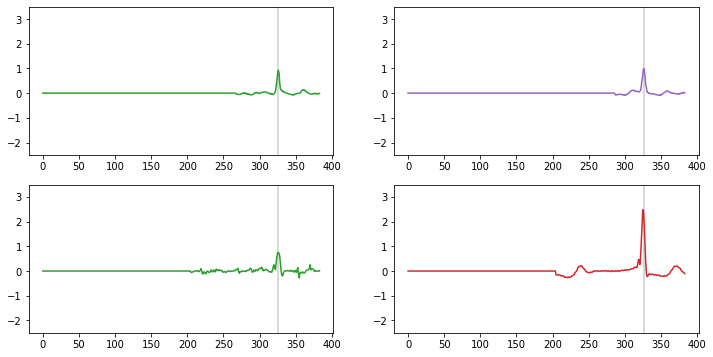

In [ ]:
ds_listS = ['sm75_1','sm75_2','sm75_3']
ds_listS_val = ['s_svdb_val','v_svdb_val']

print('S-datasets(training):',ds_listS)
ds_strS = np.zeros((0,5),dtype='U10')
for ds_name in ds_listS:
    ds_path = os.path.join(global_dsdir,ds_name+'.npy') 
    ds_this = np.load(ds_path)
    print('loaded:',ds_this.shape, ds_path)
    ds_strS=np.vstack((ds_strS,ds_this))
print('S-beats(training):',ds_strS.shape )


print('S-datasets(validation):',ds_listS_val)
ds_strS_val = np.zeros((0,5),dtype='U10')
for ds_name in ds_listS_val:
    ds_path = os.path.join(global_dsdir,ds_name+'.npy') 
    ds_this = np.load(ds_path)
    print('loaded:',ds_this.shape, ds_path)
    ds_strS_val=np.vstack((ds_strS_val,ds_this))
print('S-beats(validation):',ds_strS_val.shape )

#======================================================================
work_db = std_db_msi
#======================================================================

timestamp_start = datetime.datetime.now()

ds_selectedS = load_beat_segment2(ds_strS, work_db, S_DP, supress_NR=False)
print('')
data_xS = ds_selectedS
data_yS = ds_strS[:,4].astype('int')
print('[S_training]:',data_xS.shape,data_yS.shape)

ds_selectedS_val = load_beat_segment2(ds_strS_val, work_db, S_DP, supress_NR=False)
print('')
data_xS_val = ds_selectedS_val
data_yS_val = ds_strS_val[:,4].astype('int')
print('[S_validation]:',data_xS_val.shape,data_yS_val.shape)


timestamp_dur = datetime.datetime.now() - timestamp_start
print('\nElapsed time = ' + str(timestamp_dur))

#======================================================================
dssN = np.random.choice(np.where(data_yS==0)[0],size=1)
dssA = np.random.choice(np.where(data_yS==1)[0],size=1)
fig,ax = plt.subplots(2,2)
fig.set_size_inches(12,6)

print('Sample N',dssN,'of',len(ds_selectedS))
print(ds_strS[dssN])
ax[0,0].set_ylim(-2.5,3.5)
ax[0,0].plot(ds_selectedS[dssN[0]][:,0],color='tab:green')
ax[0,0].vlines(S_DP.fix_left,-2.5,3.5,linewidth=0.3,color='black')
ax[0,1].set_ylim(-2.5,3.5)
ax[0,1].plot(ds_selectedS[dssN[0]][:,1],color='tab:purple')
ax[0,1].vlines(S_DP.fix_left,-2.5,3.5,linewidth=0.3,color='black')

print('Sample A',dssA,'of',len(ds_selectedS))
print(ds_strS[dssA])
ax[1,0].set_ylim(-2.5,3.5)
ax[1,0].plot(ds_selectedS[dssA[0]][:,0],color='tab:green')
ax[1,0].vlines(S_DP.fix_left,-2.5,3.5,linewidth=0.3,color='black')
ax[1,1].set_ylim(-2.5,3.5)
ax[1,1].plot(ds_selectedS[dssA[0]][:,1],color='tab:red')
ax[1,1].vlines(S_DP.fix_left,-2.5,3.5,linewidth=0.3,color='black')
#======================================================================


### [ train s ]

Training model [S]: on ['sm75_1', 'sm75_2', 'sm75_3']
Epoch 1/300
137/137 [==============================] - 7s 50ms/step - loss: 0.3410 - accuracy: 0.8555 - val_loss: 0.6512 - val_accuracy: 0.8166
Epoch 2/300
137/137 [==============================] - 7s 48ms/step - loss: 0.1661 - accuracy: 0.9364 - val_loss: 0.7343 - val_accuracy: 0.8232
Epoch 3/300
137/137 [==============================] - 7s 49ms/step - loss: 0.1135 - accuracy: 0.9607 - val_loss: 1.0303 - val_accuracy: 0.7729
Epoch 4/300
137/137 [==============================] - 7s 49ms/step - loss: 0.0916 - accuracy: 0.9668 - val_loss: 1.0646 - val_accuracy: 0.8040
Epoch 5/300
137/137 [==============================] - 7s 49ms/step - loss: 0.0822 - accuracy: 0.9671 - val_loss: 1.1205 - val_accuracy: 0.8003
Epoch 6/300
137/137 [==============================] - 7s 49ms/step - loss: 0.0628 - accuracy: 0.9762 - val_loss: 1.2243 - val_accuracy: 0.8018
Epoch 7/300
137/137 [==============================] - 7s 48ms/step - loss: 0.0626

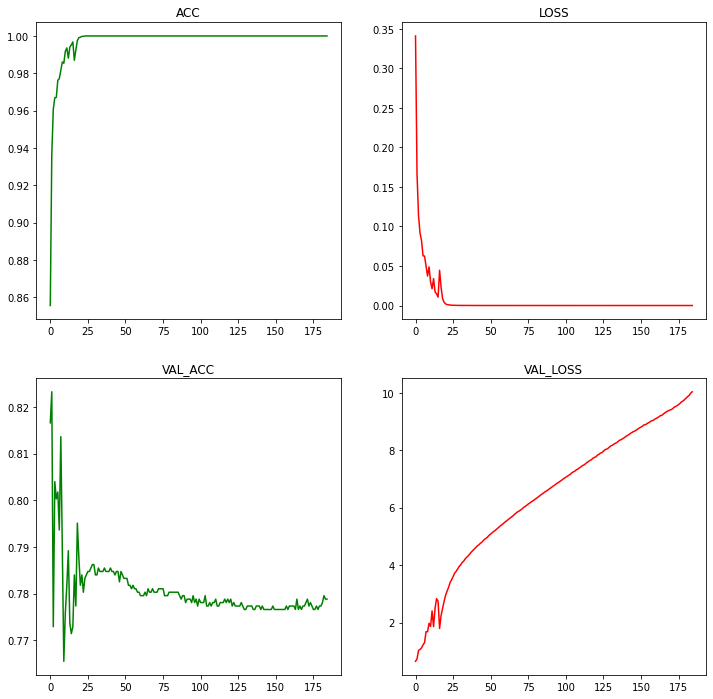

In [ ]:
ds_modelS = 'Sa' + ''

modelS=get_modelCNN_2a(False,S_DP.vdim)
# Start Training---------------------------------------------------------
timestamp_start = datetime.datetime.now()
print('Training model [S]:', 'on',ds_listS)
history = modelS.fit(
                    data_xS, data_yS,
                    #batch_size=1000,
                    epochs=300,
                    callbacks=cb_listr,
                    validation_data= (data_xS_val, data_yS_val),
                    shuffle=True,
                    verbose=1)

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))
# End Training---------------------------------------------------------

fig,ax = plt.subplots(2,2)
fig.set_size_inches(12,12)
ax[0,0].set_title('ACC')
ax[0,0].plot(history.history['accuracy'],color='green')
ax[0,1].set_title('LOSS')
ax[0,1].plot(history.history['loss'],color='red')

ax[1,0].set_title('VAL_ACC')
ax[1,0].plot(history.history['val_accuracy'],color='green')
ax[1,1].set_title('VAL_LOSS')
ax[1,1].plot(history.history['val_loss'],color='red')

#======================================================================
#======================================================================

# save this model
model_pathS = os.path.join(global_modeldir, ds_modelS+'.h5')
modelS.save_weights(model_pathS)
print('Saved Model Weights [S] at : '+ str(model_pathS))


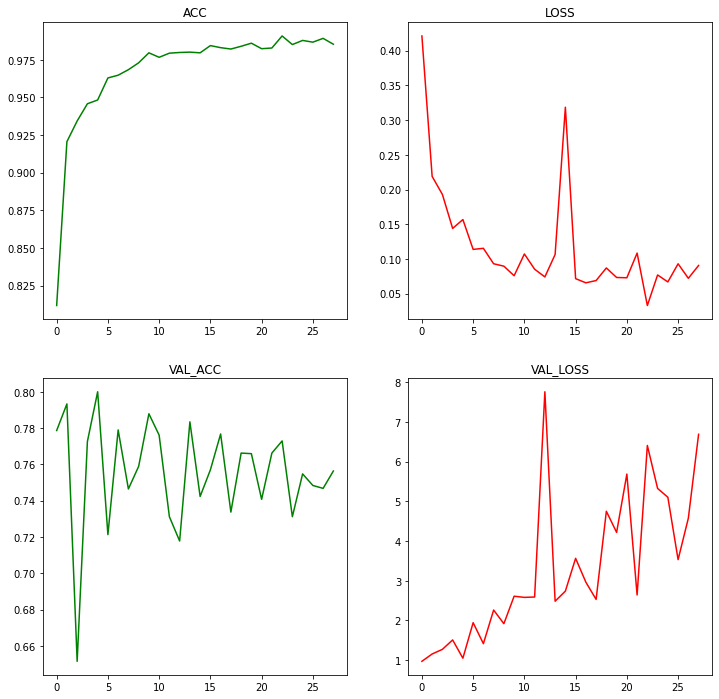

In [ ]:
fig,ax = plt.subplots(2,2)
fig.set_size_inches(12,12)
ax[0,0].set_title('ACC')
ax[0,0].plot(history.history['accuracy'],color='green')
ax[0,1].set_title('LOSS')
ax[0,1].plot(history.history['loss'],color='red')

ax[1,0].set_title('VAL_ACC')
ax[1,0].plot(history.history['val_accuracy'],color='green')
ax[1,1].set_title('VAL_LOSS')
ax[1,1].plot(history.history['val_loss'],color='red')


## [Train V ]

### [ load data ]

V-datasets: ['vd']
loaded: (2772, 5) /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/vd.npy
V-beats: (2772, 5)

[V]: (2772, 384, 2) (2772,)

Elapsed time = 0:00:06.073451
Sample N [2540] of 2772
[['mitdb' '233' '745' '1608' '0']]
Sample A [45] of 2772
[['mitdb' '114' '708' '383' '1']]


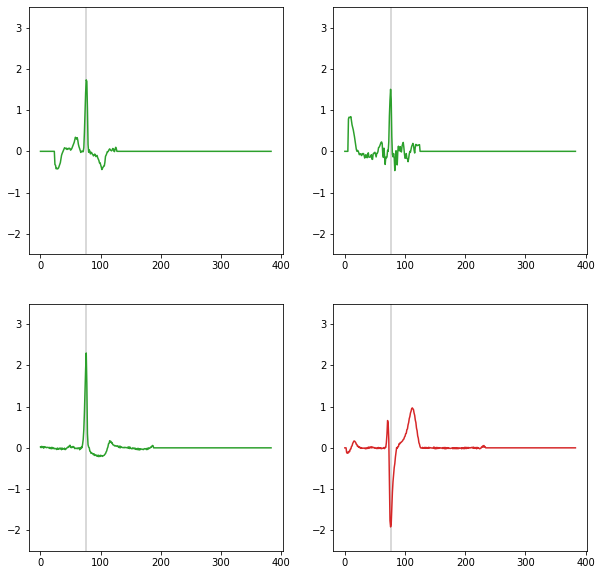

In [ ]:
ds_listV = ['vm75_1','vm75_2','vm75_3']
ds_listV_val = ['v_indb_val']

print('V-datasets(training):',ds_listV)
ds_strV = np.zeros((0,5),dtype='U10')
for ds_name in ds_listV:
    ds_path = os.path.join(global_dsdir,ds_name+'.npy') 
    ds_this = np.load(ds_path)
    print('loaded:',ds_this.shape, ds_path)
    ds_strV=np.vstack((ds_strV,ds_this))
print('V-beats(training):',ds_strV.shape )

print('V-datasets(validation):',ds_listV_val)
ds_strV_val = np.zeros((0,5),dtype='U10')
for ds_name in ds_listV_val:
    ds_path = os.path.join(global_dsdir,ds_name+'.npy') 
    ds_this = np.load(ds_path)
    print('loaded:',ds_this.shape, ds_path)
    ds_strV_val=np.vstack((ds_strV_val,ds_this))
print('V-beats(validation):',ds_strV_val.shape )


#======================================================================
work_db = std_db_msi
#======================================================================

timestamp_start = datetime.datetime.now()

ds_selectedV = load_beat_segment2(ds_strV, work_db, V_DP, supress_NR=False)
print('')
data_xV = ds_selectedV
data_yV = ds_strV[:,4].astype('int')
print('[V_training]:',data_xV.shape,data_yV.shape)

ds_selectedV_val = load_beat_segment2(ds_strV_val, work_db, V_DP, supress_NR=False)
print('')
data_xV_val = ds_selectedV_val
data_yV_val = ds_strV_val[:,4].astype('int')
print('[V_validation]:',data_xV_val.shape,data_yV_val.shape)

timestamp_dur = datetime.datetime.now() - timestamp_start
print('\nElapsed time = ' + str(timestamp_dur))

#======================================================================
dssN = np.random.choice(np.where(data_yV==0)[0],size=1)
dssA = np.random.choice(np.where(data_yV==1)[0],size=1)
fig,ax = plt.subplots(2,2)
fig.set_size_inches(10,10)

print('Sample N',dssN,'of',len(ds_selectedV))
print(ds_strV[dssN])
ax[0,0].set_ylim(-2.5,3.5)
ax[0,0].plot(ds_selectedV[dssN[0]][:,0],color='tab:green')
ax[0,0].vlines(V_DP.fix_left,-2.5,3.5,linewidth=0.3,color='black')
ax[0,1].set_ylim(-2.5,3.5)
ax[0,1].plot(ds_selectedV[dssN[0]][:,1],color='tab:green')
ax[0,1].vlines(V_DP.fix_left,-2.5,3.5,linewidth=0.3,color='black')

print('Sample A',dssA,'of',len(ds_selectedV))
print(ds_strV[dssA])
ax[1,0].set_ylim(-2.5,3.5)
ax[1,0].plot(ds_selectedV[dssA[0]][:,0],color='tab:green')
ax[1,0].vlines(V_DP.fix_left,-2.5,3.5,linewidth=0.3,color='black')
ax[1,1].set_ylim(-2.5,3.5)
ax[1,1].plot(ds_selectedV[dssA[0]][:,1],color='tab:red')
ax[1,1].vlines(V_DP.fix_left,-2.5,3.5,linewidth=0.3,color='black')
#======================================================================


### [ train v ]

Training model [V]: on ['vd']
Epoch 1/300
87/87 [==============================] - 18s 205ms/step - loss: 0.3316 - accuracy: 0.8766
Epoch 2/300
87/87 [==============================] - 18s 205ms/step - loss: 0.1444 - accuracy: 0.9517
Epoch 3/300
87/87 [==============================] - 18s 203ms/step - loss: 0.1209 - accuracy: 0.9589
Epoch 4/300
87/87 [==============================] - 18s 205ms/step - loss: 0.0934 - accuracy: 0.9675
Epoch 5/300
87/87 [==============================] - 18s 205ms/step - loss: 0.0832 - accuracy: 0.9701
Epoch 6/300
87/87 [==============================] - 18s 205ms/step - loss: 0.0700 - accuracy: 0.9769
Epoch 7/300
87/87 [==============================] - 18s 203ms/step - loss: 0.0618 - accuracy: 0.9816
Epoch 8/300
87/87 [==============================] - 18s 205ms/step - loss: 0.0680 - accuracy: 0.9823
Epoch 9/300
87/87 [==============================] - 18s 207ms/step - loss: 0.0674 - accuracy: 0.9812
Epoch 10/300
87/87 [==============================] 

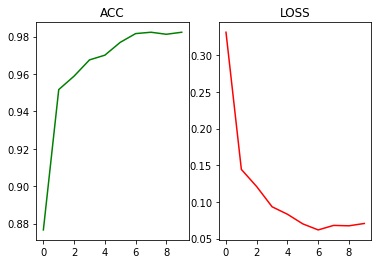

In [ ]:
ds_modelV = 'Va' + ''

modelV=get_modelCNN_2a(False,V_DP.vdim)
# Start Training---------------------------------------------------------
timestamp_start = datetime.datetime.now()
print('Training model [V]:', 'on',ds_listV)
history = modelV.fit(
                    data_xV, data_yV,
                    #batch_size=1000,
                    epochs=300,
                    callbacks=cb_listr,
                    validation_data=(data_xV_val, data_yV_val),
                    shuffle=True,
                    verbose=1)

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))
# End Training---------------------------------------------------------

fig,ax = plt.subplots(2,2)
fig.set_size_inches(12,12)
ax[0,0].set_title('ACC')
ax[0,0].plot(history.history['accuracy'],color='green')
ax[0,1].set_title('LOSS')
ax[0,1].plot(history.history['loss'],color='red')

ax[1,0].set_title('VAL_ACC')
ax[1,0].plot(history.history['val_accuracy'],color='green')
ax[1,1].set_title('VAL_LOSS')
ax[1,1].plot(history.history['val_loss'],color='red')

#======================================================================
#======================================================================

# save this model
model_pathV = os.path.join(global_modeldir, ds_modelV+'.h5')
modelV.save_weights(model_pathV)
print('Saved Model Weights [V] at : '+ str(model_pathV))


# [ TESTING ]

### [ define testing functions ]

In [ ]:
def perform_record_test(modelA, A_DP, glabels, sel_rec, sbi, sel_NR_count, nr_supress):
    #gS_LABELS, gV_LABELS, gA_LABELS = [N_Label,S_Label], [N_Label,V_Label], [N_Label,A_Label]
    abnlabel = glabels[1]
    print('\n==============================================')
    print(sel_rec.name)
    print('==============================================')
    #<<----------------------------------------------- Select Normal Rhythm
    nr_indices =  repeat_array(sbi.NRBi, sel_NR_count, 0)
    nr_count = len(nr_indices)
    if nr_count!=sel_NR_count:
        print('WARNING: count NR mismatch.... using',nr_count)        

    if nr_count==0:
        print('ERROR: No NR beat ....skip') 
        return [],[], [],[], [],[]
        #pred_res_S, conf_matrix_S, 
    else:
        #<<----------------------------------------------- Examine NR supress
        if nr_supress:
             #<<----------------------------------------------- NR is zero
            sig_NRA = np.zeros((nr_count,A_DP.vdim),dtype='float')
        else:
            #<<----------------------------------------------- Extract Record NR
            sig_NRA = np.zeros((0,A_DP.vdim),dtype='float')
            if A_DP.input_type=='fix':
                for i in range(0,nr_count):
                    d_NR,_ = sbi.get_signal_data_fix_samples(nr_indices[i],A_DP.fix_left,A_DP.fix_right)
                    sig_NRA = np.vstack((sig_NRA,d_NR))
            elif A_DP.input_type=='var':
                for i in range(0,nr_count):
                    d_NR,dpk,_= sbi.get_signal_data_var(nr_indices[i])
                    d_NR = pad_or_truncate(d_NR,dpk,A_DP.fix_left,A_DP.fix_right,A_DP.pad_value,A_DP.suppress_peak_len)
                    sig_NRA = np.vstack((sig_NRA,d_NR))
            else:
                print('Invalid Input Type')
        #<<------------------------------------------------------------ generate record data S type
        data_x = np.zeros((0,A_DP.vdim,2))
        nrc = 0
        if A_DP.input_type=='fix':
            for i in range(0,sbi.rp_count):
                d_CR,_ = sbi.get_signal_data_fix_samples(i,A_DP.fix_left,A_DP.fix_right)
                d_NR = sig_NRA[nrc%nr_count]
                d_data = np.expand_dims(np.transpose(np.vstack((d_NR,d_CR))),axis=0)
                data_x = np.vstack((data_x,d_data))
                nrc+=1
        elif A_DP.input_type=='var':
            for i in range(0,sbi.rp_count):
                d_CR,dpk,_= sbi.get_signal_data_var(i)
                d_CR = pad_or_truncate(d_CR,dpk,A_DP.fix_left,A_DP.fix_right,A_DP.pad_value,A_DP.suppress_peak_len)
                d_NR = sig_NRA[nrc%nr_count]
                d_data = np.expand_dims(np.transpose(np.vstack((d_NR,d_CR))),axis=0)
                data_x = np.vstack((data_x,d_data))
                nrc+=1
        else:
            print('Invalid Input Type')

        #------------------------------------------------------------ format record data

        data_y = (sbi.rli_curr!=N_Label).astype('int') # all non-N are abnormal

        #------------------------------------------------------------ manual prediction S
        print('\n[All Samples]:',len(data_y))
        predx = modelA.predict( data_x ) # - each row is a prediction of a sample
        pred_res = predx.argmax(axis=1)
        conf_matrix = np.zeros((2,2),dtype='int32')
        conf_matrix[0,0] = len(np.where((data_y==0)&(pred_res==0))[0])
        conf_matrix[0,1] = len(np.where((data_y==0)&(pred_res==1))[0])
        conf_matrix[1,0] = len(np.where((data_y==1)&(pred_res==0))[0])
        conf_matrix[1,1] = len(np.where((data_y==1)&(pred_res==1))[0])
        print('\tConfusion Matrix [N/A]') # all non-N are abnormal
        print(print_conf_matrix( conf_matrix,'', gA_LABELS)) 
        print_performance( get_performance(conf_matrix) ,gA_LABELS ) 
        
        #------------------------------------------------------------ manual prediction Not N
        iact = np.where((sbi.rli_curr==abnlabel)|(sbi.rli_curr==N_Label))[0]
        data_yC =  data_y[iact] # only abn are abnormal
        pred_resC = pred_res[iact]
        print('\n[Class Samples]:',len(data_yC))
        conf_matrix_C = np.zeros((2,2),dtype='int32')
        conf_matrix_C[0,0] = len(np.where((data_yC==0)&(pred_resC==0))[0])
        conf_matrix_C[0,1] = len(np.where((data_yC==0)&(pred_resC==1))[0])
        conf_matrix_C[1,0] = len(np.where((data_yC==1)&(pred_resC==0))[0])
        conf_matrix_C[1,1] = len(np.where((data_yC==1)&(pred_resC==1))[0])      
        print('\tConfusion Matrix [N/'+abnlabel+']')
        print(print_conf_matrix( conf_matrix_C,'', glabels)) #logit('\t'+str(cmx))
        print_performance( get_performance(conf_matrix_C) , glabels ) 

    return pred_res, pred_resC, conf_matrix, conf_matrix_C, data_y, data_yC



## [ load models ]

In [ ]:
ds_modelS = 'Sa'       # SELECT MODEL WEIGHTS TO TEST UPON

model_pathS = os.path.join(global_modeldir, ds_modelS +'.h5')
modelS=get_modelCNN_2a(False,S_DP.vdim)
modelS.load_weights(model_pathS)
print('Loaded Model weights '+ str(model_pathS))
##<----------------------------------------------
##<----------------------------------------------
##<----------------------------------------------
work_dbS = std_db_s
##<----------------------------------------------


Loaded Model weights /content/drive/My Drive/Masters/workdir/ecg_data/db_model/Sa.h5


In [ ]:
ds_modelV = 'Va'       # SELECT MODEL WEIGHTS TO TEST UPON

model_pathV = os.path.join(global_modeldir, ds_modelV +'.h5')
modelV=get_modelCNN_2a(False,V_DP.vdim)
modelV.load_weights(model_pathV)
print('Loaded Model weights '+ str(model_pathV))
##<----------------------------------------------
##<----------------------------------------------
##<----------------------------------------------
work_dbV = std_db_i
##<----------------------------------------------


Loaded Model weights /content/drive/My Drive/Masters/workdir/ecg_data/db_model/Va.h5


## [ Testing - Database ]

### [ Test S ]

In [ ]:
##<----------------------------------------------
sel_NR_count = 30
nr_supress=False
print('Testing database:',work_dbS.keys())
print('NR_Count:', sel_NR_count)


conf_matrix_gAS = np.zeros((2,2),dtype='int32') # confusion matrix S
conf_matrix_gCS = np.zeros((2,2),dtype='int32') # confusion matrix Combined

#<<----------------------------------------
timestamp_start = datetime.datetime.now()
#<<----------------------------------------

for idb in work_dbS.keys():
    #<<--------------------
    sel_db = work_dbS[idb]
    for irec in sel_db.recs_tag:
        #<<--------------------
        sel_rec = sel_db.get_record(irec)
        print('\n==============================================')
        #print(sel_rec.name)
        sbi = sel_rec.read_binfo()
        prAS,prCS,cmAS,cmCS,_,_ = perform_record_test(modelS, S_DP, gS_LABELS, sel_rec, sbi, sel_NR_count, nr_supress)

        if len(cmAS)!=0 and len(cmCS)!=0 :
            conf_matrix_gAS += cmAS
            conf_matrix_gCS += cmCS
    # end loop
print('\n==============================================')
print('\tGlobal Confusion Matrix [All]')
print(print_conf_matrix( conf_matrix_gAS,'', gA_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(conf_matrix_gAS) ,gA_LABELS ) 

print('\n==============================================')
print('\tGlobal Confusion Matrix [Class]')
print(print_conf_matrix( conf_matrix_gCS,'', gS_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(conf_matrix_gCS) ,gS_LABELS ) 

#------------------------------------------------------------
print('\n==============================================')
timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))

Testing database: dict_keys(['svdb'])
NR_Count: 30


svdb_888

[All Samples]: 2311
	Confusion Matrix [N/A]
A\P	N	A
N	1408	781
A	7	115

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.66	1.0	0.64	0.94
A	0.66	0.13	0.94	0.64

[Class Samples]: 2257
	Confusion Matrix [N/S]
A\P	N	S
N	1408	781
S	4	64

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.65	1.0	0.64	0.94
S	0.65	0.08	0.94	0.64


svdb_820

[All Samples]: 2350
	Confusion Matrix [N/A]
A\P	N	A
N	2161	0
A	2	187

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	1.0	1.0	1.0	0.99
A	1.0	1.0	0.99	1.0

[Class Samples]: 2346
	Confusion Matrix [N/S]
A\P	N	S
N	2161	0
S	1	184

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	1.0	1.0	1.0	0.99
S	1.0	1.0	0.99	1.0


svdb_825

[All Samples]: 2796
	Confusion Matrix [N/A]
A\P	N	A
N	142	2509
A	0	145

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.1	1.0	0.05	1.0
A	0.1	0.05	1.0	0.05

[Class Samples]: 2796
	Confusion Matrix [N/S]
A\P	N	S
N	142	2509
S	0	145

Performance for 2 classes
Class	ACC	

### [ Test V ]

In [ ]:
##<----------------------------------------------
sel_NR_count = 30
nr_supress=False
print('Testing database:',work_dbV.keys())
print('NR_Count:', sel_NR_count)



conf_matrix_gAV = np.zeros((2,2),dtype='int32') # confusion matrix S
conf_matrix_gCV = np.zeros((2,2),dtype='int32') # confusion matrix Combined

#<<----------------------------------------
timestamp_start = datetime.datetime.now()
#<<----------------------------------------
print('\n----------------------------------------')

for idb in work_dbV.keys():
    #<<--------------------
    sel_db = work_dbV[idb]
    for irec in sel_db.recs_tag:
        #<<--------------------
        sel_rec = sel_db.get_record(irec)
        print('\n==============================================')
        #print(sel_rec.name)
        sbi = sel_rec.read_binfo()
        prAV,prCV,cmAV,cmCV,_,_ = perform_record_test(modelV, V_DP, gV_LABELS, sel_rec, sbi, sel_NR_count, nr_supress)

        if len(cmAV)!=0 and len(cmCV)!=0 :
            conf_matrix_gAV += cmAV
            conf_matrix_gCV += cmCV
    # end loop
print('\n==============================================')
print('\tGlobal Confusion Matrix [All]')
print(print_conf_matrix( conf_matrix_gAV,'', gA_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(conf_matrix_gAV) ,gA_LABELS ) 

print('\n==============================================')
print('\tGlobal Confusion Matrix [Class]')
print(print_conf_matrix( conf_matrix_gCV,'', gV_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(conf_matrix_gCV) ,gV_LABELS ) 

#------------------------------------------------------------
print('\n==============================================')
timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))

Testing database: dict_keys(['incartdb'])
NR_Statergy: pure
NR_Count: 30

----------------------------------------


incartdb_I63

[All Samples]: 1992
	Confusion Matrix [N/A]
A\P	N	A
N	1843	2
A	9	138

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.99	1.0	1.0	0.94
A	0.99	0.99	0.94	1.0

[Class Samples]: 1991
	Confusion Matrix [N/V]
A\P	N	V
N	1843	2
V	8	138

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.99	1.0	1.0	0.95
V	0.99	0.99	0.95	1.0


incartdb_I13

[All Samples]: 2021
	Confusion Matrix [N/A]
A\P	N	A
N	1791	0
A	0	230

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	1.0	1.0	1.0	1.0
A	1.0	1.0	1.0	1.0

[Class Samples]: 2021
	Confusion Matrix [N/V]
A\P	N	V
N	1791	0
V	0	230

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	1.0	1.0	1.0	1.0
V	1.0	1.0	1.0	1.0


incartdb_I67

[All Samples]: 2973
	Confusion Matrix [N/A]
A\P	N	A
N	2392	44
A	6	531

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.98	1.0	0.98	0.99
A	0.98	0.92	0.99	0.98

[Class Samples]: 2968
	Confusion Matrix [N

## [ Testing - Record ]

### [ select record ]

In [ ]:
sel_db = std_incartdb
sel_rec = sel_db.get_record('I54') # incartdb_I54 svdb_825
ds_name = sel_rec.name
#<<-----------------------------------------------
sbi = sel_rec.read_binfo()
sbi.map_ants2int(g_STD_MAP)
sel_signal = sel_rec.read_data(g_SIG2)
print(sel_rec.name)

incartdb_I54


### [ S test  ]

In [ ]:
sel_NR_count = 10
nr_supress=False
print('Testing record:',sel_rec.name)
print('NR_Count:', sel_NR_count)


#<<-----------------------------------------------


#<<-----------------------------------------------
timestamp_start = datetime.datetime.now()
#<<-----------------------------------------------
prAS,prCS,cmAS,cmCS,data_yS,_ = perform_record_test(modelS, S_DP, gS_LABELS, sel_rec, sbi, sel_NR_count, nr_supress)
#<<-----------------------------------------------
timestamp_dur = datetime.datetime.now() - timestamp_start
print('\nElapsed time = ' + str(timestamp_dur))

Testing record: incartdb_I54
NR_Statergy: pure
NR_Count: 10

incartdb_I54

[All Samples]: 2361
	Confusion Matrix [N/A]
A\P	N	A
N	1528	810
A	1	22

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.66	1.0	0.65	0.96
A	0.66	0.03	0.96	0.65

[Class Samples]: 2339
	Confusion Matrix [N/S]
A\P	N	S
N	1528	810
S	0	1

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.65	1.0	0.65	1.0
S	0.65	0.0	1.0	0.65

Elapsed time = 0:00:07.781651


### [ V test ]

In [ ]:
sel_NR_count = 10
nr_supress=False
print('Testing record:',sel_rec.name)
print('NR_Count:', sel_NR_count)


#<<-----------------------------------------------


#<<-----------------------------------------------
timestamp_start = datetime.datetime.now()
#<<-----------------------------------------------
prAV,prCV,cmAV,cmCV,data_yV,_  = perform_record_test(modelV, V_DP, gV_LABELS, sel_rec, sbi, sel_NR_count, nr_supress)
#<<-----------------------------------------------
timestamp_dur = datetime.datetime.now() - timestamp_start
print('\nElapsed time = ' + str(timestamp_dur))

Testing record: incartdb_I54
NR_Statergy: pure
NR_Count: 10

incartdb_I54

[All Samples]: 2361
	Confusion Matrix [N/A]
A\P	N	A
N	2081	257
A	2	21

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.89	1.0	0.89	0.91
A	0.89	0.08	0.91	0.89

[Class Samples]: 2360
	Confusion Matrix [N/V]
A\P	N	V
N	2081	257
V	2	20

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.89	1.0	0.89	0.91
V	0.89	0.07	0.91	0.89

Elapsed time = 0:00:07.962050


### [ combined performance ]

In [ ]:
prx = np.logical_or(prAS,prAV)
daty = np.logical_or(data_yS,data_yV) 

print('\n[Combined]:',len(daty))
conf_matrix = np.zeros((2,2),dtype='int32')
conf_matrix[0,0] = len(np.where((daty==0)&(prx==0))[0])
conf_matrix[0,1] = len(np.where((daty==0)&(prx==1))[0])
conf_matrix[1,0] = len(np.where((daty==1)&(prx==0))[0])
conf_matrix[1,1] = len(np.where((daty==1)&(prx==1))[0])
print('\tConfusion Matrix [N/A]') # all non-N are abnormal
print(print_conf_matrix( conf_matrix,'', gA_LABELS)) 
print_performance( get_performance(conf_matrix) ,gA_LABELS ) 



[Combined]: 2361
	Confusion Matrix [N/A]
A\P	N	A
N	1533	805
A	1	22

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.66	1.0	0.66	0.96
A	0.66	0.03	0.96	0.66


### [ plot predictions ]

incartdb_I54
Time Interval{17s}:[1545:1562]
Beat Interval{26#}:[2004:2029]


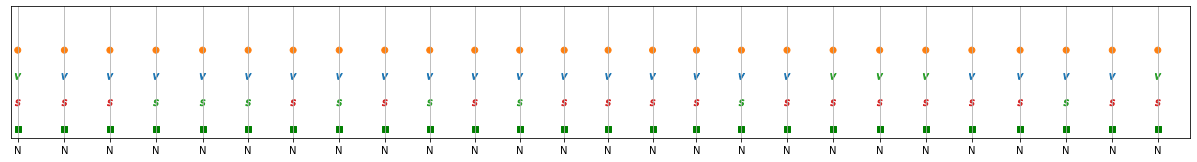

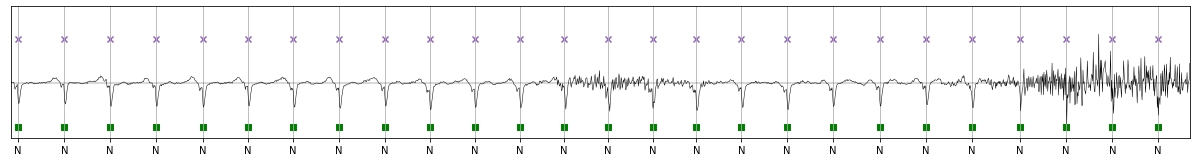

In [ ]:
#<<--------------------------------------------------------------------
x_scale = 25 * 0.0393701 # mm/sec -> inches/sec
y_scale = 10 * 0.0393701 # mm/mV -> inches/sec
y_low = -2.5
y_high = 3.5
#------------------------------------------------------------

ff=1545
tt=ff+17
sgv,_,_=plot_ecg_segment(sbi, sel_signal, 
                 ff, tt, 
                 x_scale, y_scale, y_low, y_high,
                 -2, False, 
                 [prAS,prAV, prx], 
                 [data_yS,data_yV, daty], 
                 ['tab:red','tab:blue', 'tab:orange'] ,
                 ['$S$','$V$','o'],
                 gain=1)




---

EOE

---





---

